## Script to manage data exraction from IIASA water demand NetCDF files

In [68]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import rioxarray

In [6]:
ds=xr.open_dataset('historical_dom_year_millionm3_5min_Europe_1960_2020.nc')

In [66]:
#
domwc= ds['domwc']
domww=ds['domww']

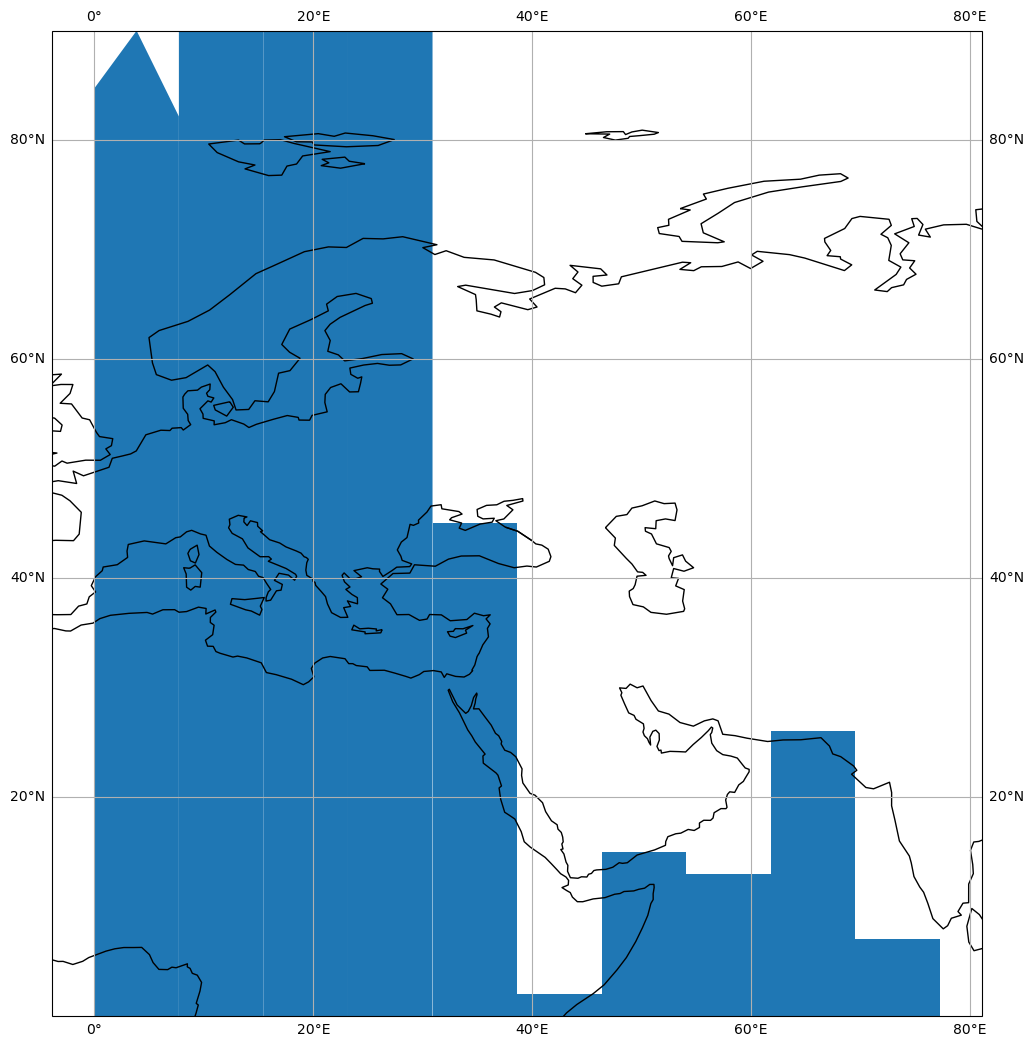

In [53]:
# code to plot the data on a map. data is the fist instance of the variable for all lat lons
fig=plt.figure(figsize=(12,24))
ax=plt.axes(projection=ccrs.PlateCarree())
domwc.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

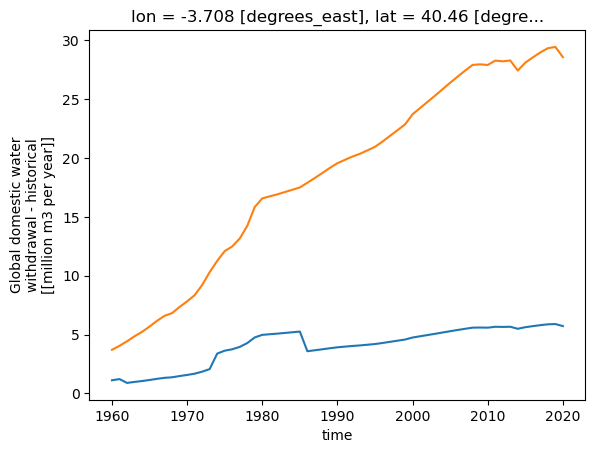

In [85]:
# Plotting the curves for one selected location
lat=domwc['lat'].values
lon=domwc['lon'].values
lat_df=pd.DataFrame({'Latitude':lat})
lon_df=pd.DataFrame({'Longitude':lon})
wc= domwc.sel(lat=40.416775,lon=-3.703790,method='nearest')
ww=domww.sel(lat=40.416775,lon=-3.703790,method='nearest')
wc.plot()
ww.plot()

In [86]:
# Read shape file
shp_file = gpd.read_file('spain_shp/es_100km.shp')
#Set the projection to the same one on the NetCDF file
shp_file = shp_file.to_crs(epsg=4326)

        time  spatial_ref   sum_value
0 1960-01-01            0  740.086792
1 1961-01-01            0  766.492615
2 1962-01-01            0  734.270264
3 1963-01-01            0  765.297363
4 1964-01-01            0  786.849426


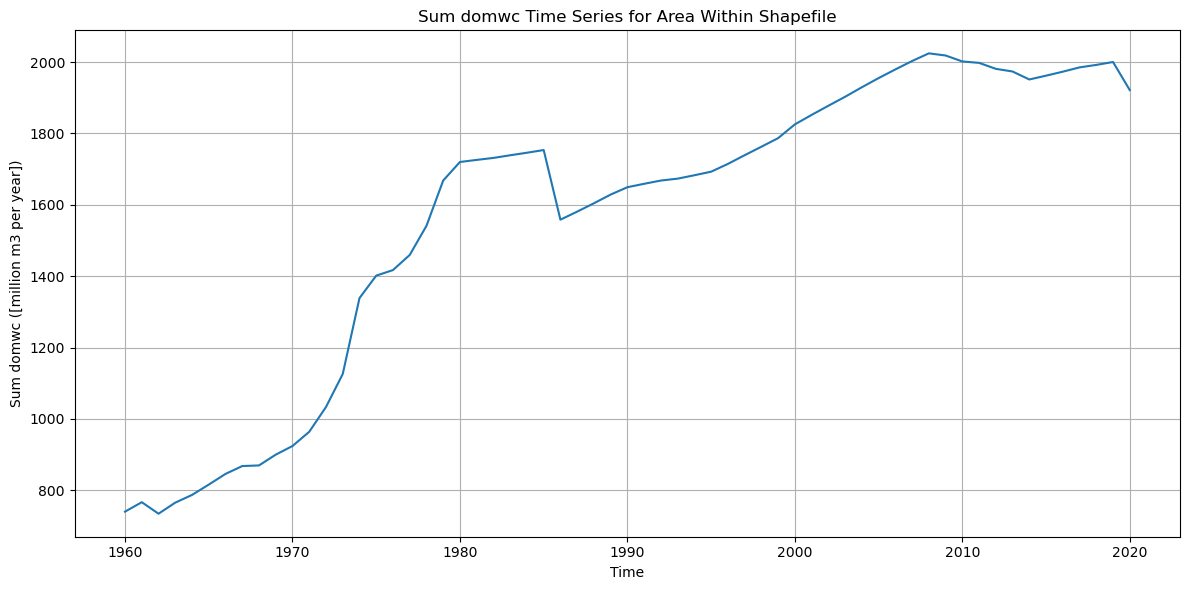

In [87]:
#Set dimentions for the variable in teh NC file
domwc= domwc.rio.set_spatial_dims(x_dim='lon',y_dim='lat')
domwc.rio.write_crs(4326,inplace=True)
clipped_data = domwc.rio.clip(shp_file.geometry, shp_file.crs, all_touched=True)
time_series_sum = clipped_data.sum(dim=['lat', 'lon'])
df = time_series_sum.to_dataframe(name='sum_value')
df = df.reset_index()

# Step 9: Print the first few rows of the DataFrame
print(df.head())

# Step 10: Visualize the time series
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['sum_value'])
plt.title(f'Sum {domwc.name} Time Series for Area Within Shapefile')
plt.xlabel('Time')
plt.ylabel(f'Sum {domwc.name} ({domwc.units})')
plt.grid(True)
plt.tight_layout()
plt.show()

In [144]:
import xarray as xr
import geopandas as gpd
import rioxarray
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import mapping

def calculate_sum_timeseries(variable, geo_file, rolling_window=7, save_csv=True):
    """
    Calculate the sum time series for a variable within a shapefile or GeoJSON area.
    
    Parameters:
    - variable: xarray DataArray, the variable from the NetCDF file
    - geo_file: str or GeoDataFrame, the path to the shapefile/GeoJSON or a GeoDataFrame
    - rolling_window: int, the window for the rolling average (default 7)
    - save_csv: bool, whether to save results to a CSV file (default True)
    
    Returns:
    - df: pandas DataFrame with the results
    """
    try:
        # Set dimensions for the variable
        variable = variable.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
        variable.rio.write_crs(4326, inplace=True)
        
        # Load the geometry file if it's a string path
        if isinstance(geo_file, str):
            geo_data = gpd.read_file(geo_file)
        elif isinstance(geo_file, gpd.GeoDataFrame):
            geo_data = geo_file
        else:
            raise ValueError("geo_file must be a file path or a GeoDataFrame")
        
        # Ensure the CRS matches
        geo_data = geo_data.to_crs(epsg=4326)
        
        # Extract the geometry
        if geo_data.geometry.geom_type.iloc[0] == 'GeometryCollection':
            # If it's a GeometryCollection, use the first geometry
            geometry = geo_data.geometry.iloc[0][0]
        else:
            # Otherwise, use the union of all geometries
            geometry = geo_data.geometry.unary_union
        
        # Clip the data to the geometry
        clipped_data = variable.rio.clip([mapping(geometry)], crs=4326, all_touched=True)
        
        # Calculate the sum for each time step
        time_series_sum = clipped_data.sum(dim=['lat', 'lon'])
        
        # Convert to DataFrame
        df = time_series_sum.to_dataframe(name='sum_value')
        df = df.reset_index()
        
        # Print the first few rows of the DataFrame
        print(df.head())
        
        # Visualize the time series
        plt.figure(figsize=(12, 6))
        plt.plot(df['time'], df['sum_value'])
        plt.title(f'Sum of {variable.name} Time Series for Area Within Geometry')
        plt.xlabel('Time')
        plt.ylabel(f'Sum of {variable.name} ({variable.units})')
        plt.grid(True)
        
        # Add a rolling average line
        rolling_avg = df['sum_value'].rolling(window=rolling_window).mean()
        plt.plot(df['time'], rolling_avg, color='red', linewidth=2, 
                 label=f'{rolling_window}-day Rolling Average')
        
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Calculate and print statistics
        print(f"\nStatistics for sum of {variable.name} within the geometry area:")
        print(f"Overall Sum: {df['sum_value'].sum():.2f} {variable.units}")
        print(f"Mean Sum per Time Step: {df['sum_value'].mean():.2f} {variable.units}")
        print(f"Minimum Sum: {df['sum_value'].min():.2f} {variable.units}")
        print(f"Maximum Sum: {df['sum_value'].max():.2f} {variable.units}")
        print(f"Standard Deviation: {df['sum_value'].std():.2f} {variable.units}")
        
        # Optionally, save to CSV
        if save_csv:
            csv_filename = f'{variable.name}_sum_timeseries_within_geometry.csv'
            df.to_csv(csv_filename, index=False)
            print(f"\nResults saved to {csv_filename}")
        
        return df
    
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

# Example usage:
# Assuming you have already read your NetCDF file
# nc_file = xr.open_dataset('path/to/your/netcdf_file.nc')

# For domc variable
# domc = nc_file['domc']  # replace 'domc' with the actual variable name in your NetCDF file
# df_domc = calculate_sum_timeseries(domc, 'path/to/your/shapefile_or_geojson.shp')

# For domw variable
# domw = nc_file['domw']  # replace 'domw' with the actual variable name in your NetCDF file
# df_domw = calculate_sum_timeseries(domw, 'path/to/your/shapefile_or_geojson.shp')

C:\Users\vsridhar\AppData\Local\Temp\ipykernel_17208\4286256687.py:44: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geometry = geo_data.geometry.unary_union


        time  spatial_ref   sum_value
0 1960-01-01            0  590.572632
1 1961-01-01            0  592.617737
2 1962-01-01            0  601.916992
3 1963-01-01            0  617.102173
4 1964-01-01            0  636.283447


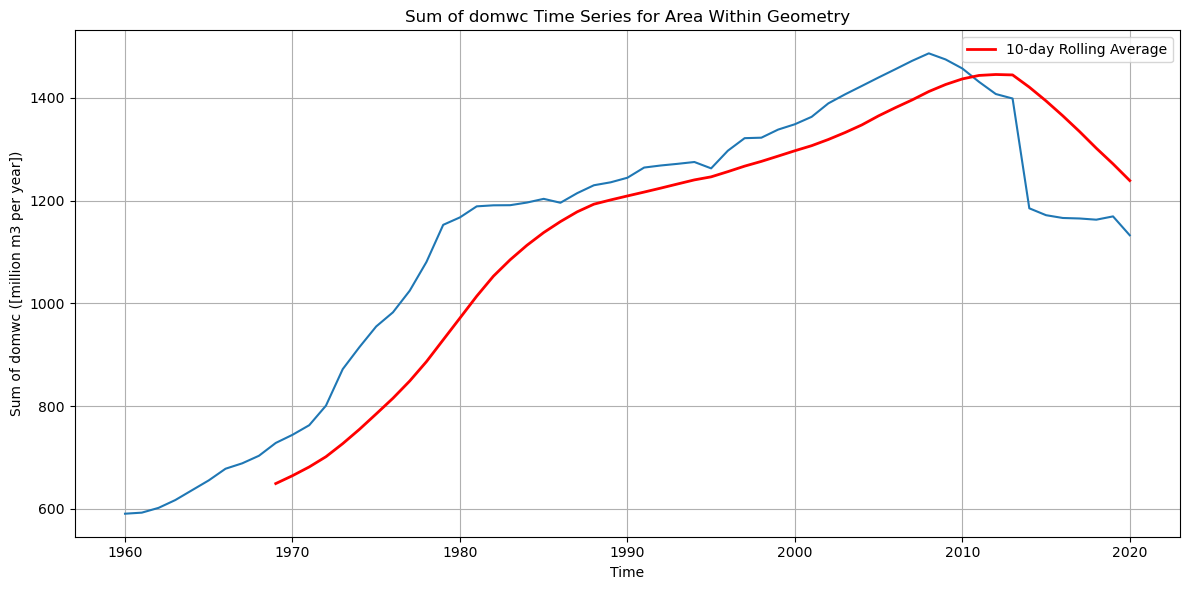


Statistics for sum of domwc within the geometry area:
Overall Sum: 68777.92 [million m3 per year]
Mean Sum per Time Step: 1127.51 [million m3 per year]
Minimum Sum: 590.57 [million m3 per year]
Maximum Sum: 1486.86 [million m3 per year]
Standard Deviation: 272.91 [million m3 per year]

Results saved to domwc_sum_timeseries_within_geometry.csv
        time  spatial_ref   sum_value
0 1960-01-01            0  848.859619
1 1961-01-01            0  865.254272
2 1962-01-01            0  889.761902
3 1963-01-01            0  925.381714
4 1964-01-01            0  966.725708


C:\Users\vsridhar\AppData\Local\Temp\ipykernel_17208\4286256687.py:44: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geometry = geo_data.geometry.unary_union


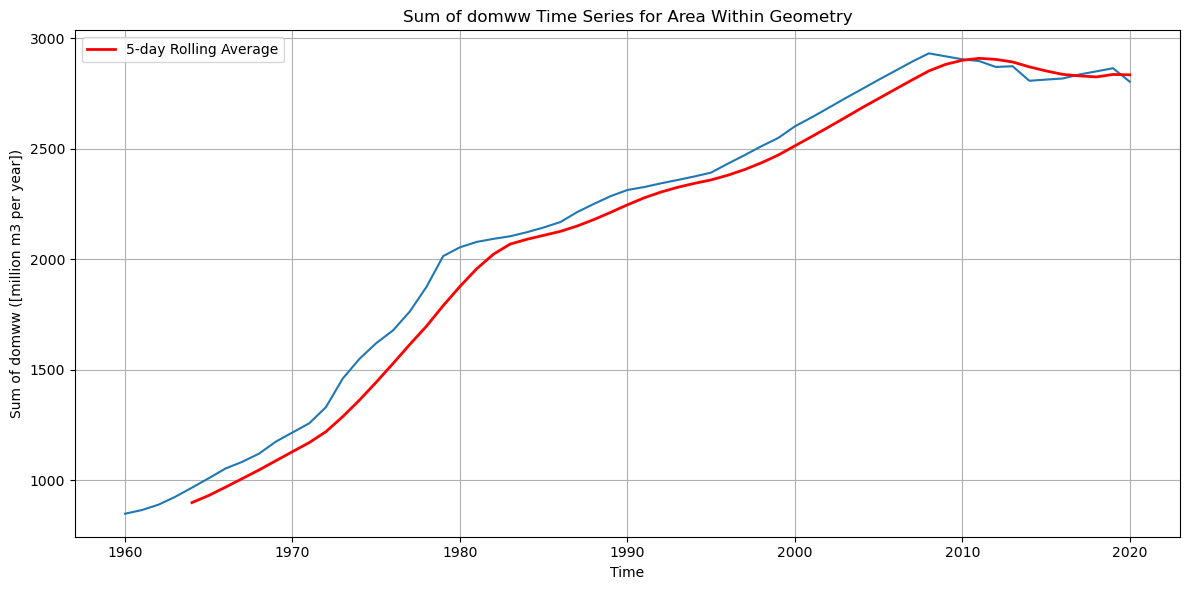


Statistics for sum of domww within the geometry area:
Overall Sum: 130467.29 [million m3 per year]
Mean Sum per Time Step: 2138.81 [million m3 per year]
Minimum Sum: 848.86 [million m3 per year]
Maximum Sum: 2931.81 [million m3 per year]
Standard Deviation: 679.43 [million m3 per year]


In [157]:
# Open your NetCDF file and shapefile
ds=xr.open_dataset('historical_dom_year_millionm3_5min_Europe_1960_2020.nc')
shp_file = gpd.read_file('greece_shp/gr_100km.shp')
# For domc variable
domwc = ds['domwc']  # replace 'domwc' with the actual variable name in your NetCDF file
df_domc = calculate_sum_timeseries(domwc, shp_file, rolling_window=10, save_csv=True)

# For domw variable
domww = ds['domww']  # replace 'domw' with the actual variable name in your NetCDF file
df_domw = calculate_sum_timeseries(domww, shp_file, rolling_window=5, save_csv=False)

C:\Users\vsridhar\AppData\Local\Temp\ipykernel_17208\4286256687.py:44: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geometry = geo_data.geometry.unary_union


        time  spatial_ref   sum_value
0 1960-01-01            0  201.705048
1 1961-01-01            0  205.123169
2 1962-01-01            0  208.413910
3 1963-01-01            0  210.869217
4 1964-01-01            0  215.785309


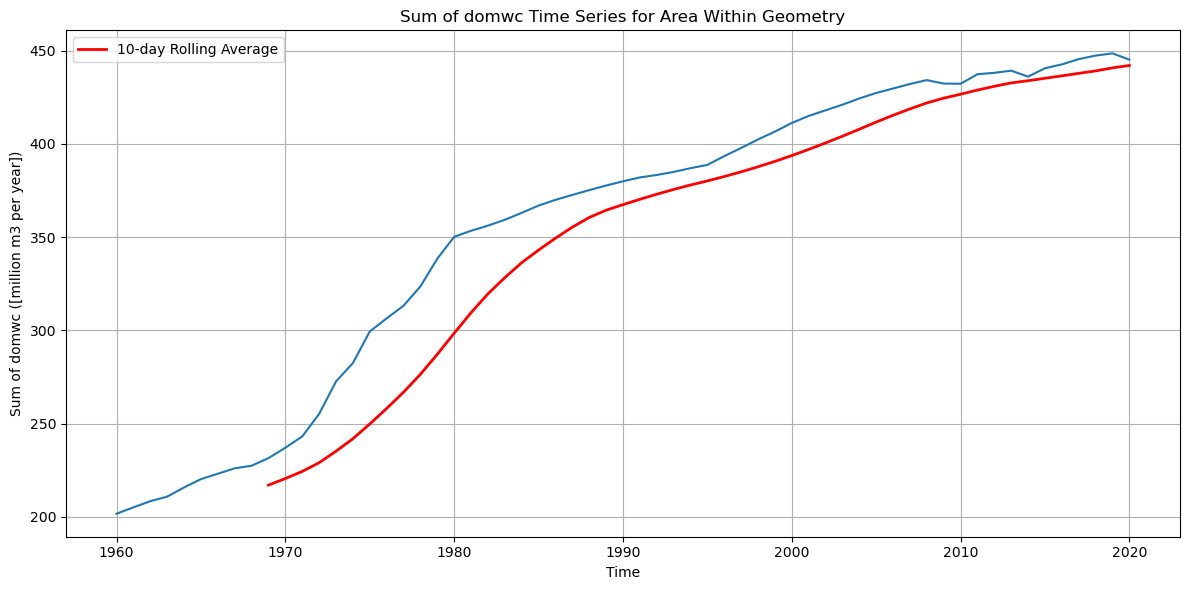


Statistics for sum of domwc within the geometry area:
Overall Sum: 21688.00 [million m3 per year]
Mean Sum per Time Step: 355.54 [million m3 per year]
Minimum Sum: 201.71 [million m3 per year]
Maximum Sum: 448.48 [million m3 per year]
Standard Deviation: 81.02 [million m3 per year]

Results saved to domwc_sum_timeseries_within_geometry.csv
        time  spatial_ref   sum_value
0 1960-01-01            0  440.506195
1 1961-01-01            0  455.981506
2 1962-01-01            0  471.764771
3 1963-01-01            0  485.963593
4 1964-01-01            0  506.370422


C:\Users\vsridhar\AppData\Local\Temp\ipykernel_17208\4286256687.py:44: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geometry = geo_data.geometry.unary_union


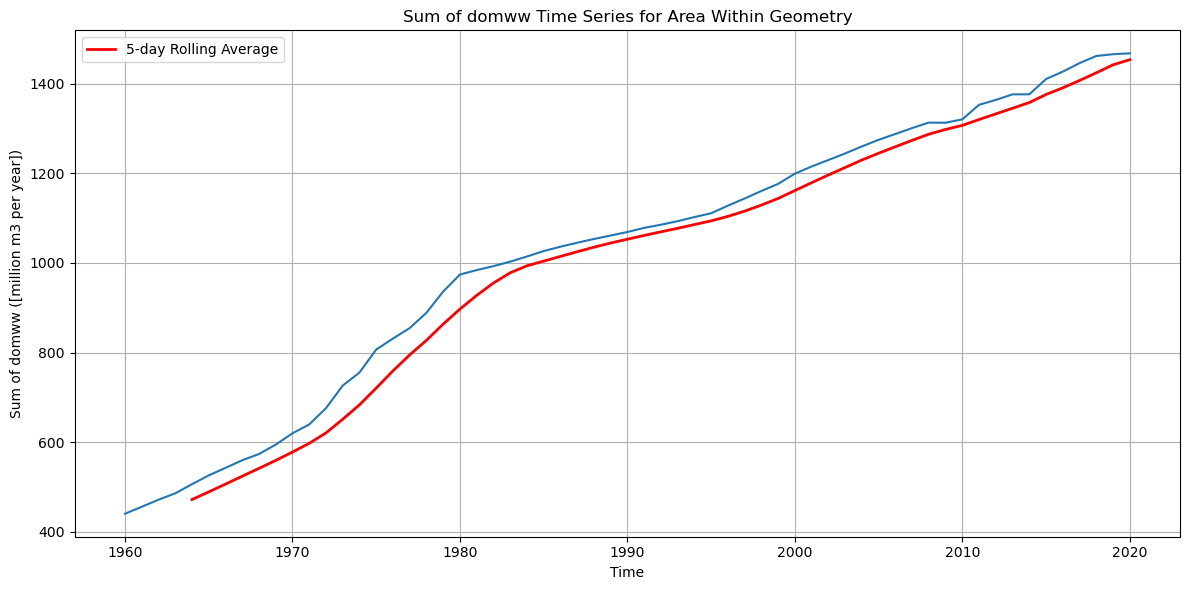


Statistics for sum of domww within the geometry area:
Overall Sum: 62323.47 [million m3 per year]
Mean Sum per Time Step: 1021.70 [million m3 per year]
Minimum Sum: 440.51 [million m3 per year]
Maximum Sum: 1467.25 [million m3 per year]
Standard Deviation: 307.13 [million m3 per year]


In [161]:
# Open your NetCDF file and shapefile
ds=xr.open_dataset('historical_dom_year_millionm3_5min_Europe_1960_2020.nc')
shp_file = gpd.read_file('sweden_shp/se_100km.shp')
# For domc variable
domwc = ds['domwc']  # replace 'domwc' with the actual variable name in your NetCDF file
df_domc = calculate_sum_timeseries(domwc, shp_file, rolling_window=10, save_csv=True)

# For domw variable
domww = ds['domww']  # replace 'domw' with the actual variable name in your NetCDF file
df_domw = calculate_sum_timeseries(domww, shp_file, rolling_window=5, save_csv=False)

In [162]:
df_domc.drop('spatial_ref',axis=1,inplace=True)
df_domc.set_index('time')
df_domw.drop('spatial_ref',axis=1,inplace=True)
df_domw.set_index('time')

,sum_value
time,
1960-01-01,440.506195
1961-01-01,455.981506
1962-01-01,471.764771
1963-01-01,485.963593
1964-01-01,506.370422
...,...
2016-01-01,1426.517334
2017-01-01,1445.477173
2018-01-01,1461.384644


In [163]:
df_combined=df_domc.merge(df_domw, how='inner', on='time')
df_combined.set_index('time',inplace=True)

<Axes: xlabel='time'>

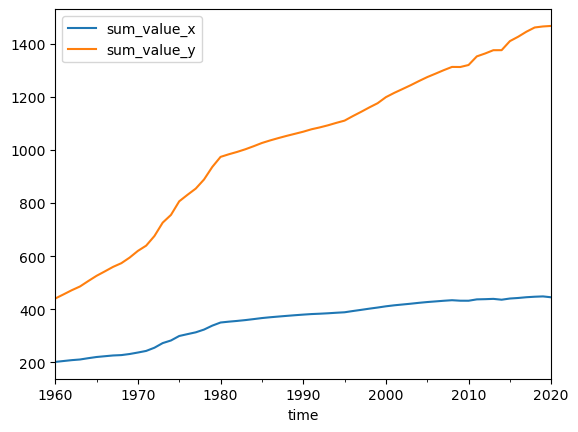

In [164]:
df_combined.plot()

In [124]:
df_domc

,time,sum_value
0,1960-01-01,740.086792
1,1961-01-01,766.492615
2,1962-01-01,734.270264
3,1963-01-01,765.297363
4,1964-01-01,786.849426
...,...,...
56,2016-01-01,1973.045776
57,2017-01-01,1985.096924
58,2018-01-01,1992.042114
59,2019-01-01,2000.175537
